In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

#from rdkit import Chem
#from rdkit.Chem.Draw import IPythonConsole
#from rdkit.Chem import Draw

import shap
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer ,mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate , cross_val_score

from tqdm import tqdm

In [3]:
data= pd.read_csv("data\CEPDB_25000.csv")

In [4]:
data.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str,ml_phase
0,1503301,C1C=c2c-3c([SiH2]c4cc[nH]c-34)c3cnc(cc3c2=C1)-...,C21H13N5SSi,395.5207,8.236346,0.641905,197.474780,-5.241905,1.463722,-3.778183,[nH]1ccc2[SiH2]c3c(-c12)c1=CCC=c1c1cc(ncc31)-c...,train
1,2540778,[SiH2]1C=c2ccc3sc4c([nH]c5cc(-c6scc7C=C[SiH2]c...,C24H17NS2Si3,467.7953,5.738034,0.427601,206.524926,-5.027601,1.427000,-3.600601,[nH]1c2cc(-c3scc4C=C[SiH2]c34)c3=C[SiH2]C=c3c2...,train
2,615142,c1[nH]cc2c1ccc1cnc3cc4cc([se]c4cc3c21)-c1ncncn1,C20H11N5Se,400.3019,5.038762,0.873908,88.737230,-5.473908,2.042885,-3.431022,c1cc2cnc3cc4cc([se]c4cc3c2c2c[nH]cc12)-c1ncncn1,train
3,124449,C1C=c2c(cc3ccc4c5cnccc5c5cocc5c4c3c2=C1)-c1cccs1,C26H15NOS,389.4765,3.507048,0.732531,73.682314,-5.332531,2.162777,-3.169754,c1ccc(s1)-c1cc2ccc3c4cnccc4c4cocc4c3c2c2=CCC=c12,train
4,1008442,C1cc2ccc3sc4cc5ccc6c[SiH2]cc6c5cc4c3c2c1,C21H14SSi,326.4936,4.020859,0.630730,98.112205,-5.230730,1.978195,-3.252535,c1cc2sc3cc4ccc5c[SiH2]cc5c4cc3c2c2cCcc12,train


In [5]:
data.columns

Index(['id', 'SMILES_str', 'stoich_str', 'mass', 'pce', 'voc', 'jsc',
       'e_homo_alpha', 'e_gap_alpha', 'e_lumo_alpha', 'tmp_smiles_str',
       'ml_phase'],
      dtype='object')

In [6]:
data=data.drop(["ml_phase","id"],axis=1)

In [7]:
data

,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
0,C1C=c2c-3c([SiH2]c4cc[nH]c-34)c3cnc(cc3c2=C1)-...,C21H13N5SSi,395.5207,8.236346,0.641905,197.474780,-5.241905,1.463722,-3.778183,[nH]1ccc2[SiH2]c3c(-c12)c1=CCC=c1c1cc(ncc31)-c...
1,[SiH2]1C=c2ccc3sc4c([nH]c5cc(-c6scc7C=C[SiH2]c...,C24H17NS2Si3,467.7953,5.738034,0.427601,206.524926,-5.027601,1.427000,-3.600601,[nH]1c2cc(-c3scc4C=C[SiH2]c34)c3=C[SiH2]C=c3c2...
2,c1[nH]cc2c1ccc1cnc3cc4cc([se]c4cc3c21)-c1ncncn1,C20H11N5Se,400.3019,5.038762,0.873908,88.737230,-5.473908,2.042885,-3.431022,c1cc2cnc3cc4cc([se]c4cc3c2c2c[nH]cc12)-c1ncncn1
3,C1C=c2c(cc3ccc4c5cnccc5c5cocc5c4c3c2=C1)-c1cccs1,C26H15NOS,389.4765,3.507048,0.732531,73.682314,-5.332531,2.162777,-3.169754,c1ccc(s1)-c1cc2ccc3c4cnccc4c4cocc4c3c2c2=CCC=c12
4,C1cc2ccc3sc4cc5ccc6c[SiH2]cc6c5cc4c3c2c1,C21H14SSi,326.4936,4.020859,0.630730,98.112205,-5.230730,1.978195,-3.252535,c1cc2sc3cc4ccc5c[SiH2]cc5c4cc3c2c2cCcc12
...,...,...,...,...,...,...,...,...,...,...
24995,C1C=c2ccc3[SiH2]c4c([nH]c5cc(oc45)-c4scc5[SiH2...,C21H15NOSSi2,385.5935,2.045460,0.156053,201.727494,-4.756053,1.445501,-3.310552,[nH]1c-2c([SiH2]c3ccc4=CCC=c4c-23)c2oc(cc12)-c...
24996,C1C=c2ccc3cc4[se]c5C=C(Cc5c4cc3c2=C1)C1=CC=CC1,C23H16Se,371.3394,2.097438,0.292111,110.506690,-4.892111,1.901301,-2.990811,C1=CC=C(C1)C1=Cc2[se]c3cc4ccc5=CCC=c5c4cc3c2C1
24997,C1C=Cc2ccc3c(sc4cc(-c5nccs5)c5c[nH]cc5c34)c12,C20H12N2S2,344.4608,2.183358,0.434750,77.291785,-5.034750,2.132758,-2.901991,C1=Cc2ccc3c(sc4cc(-c5nccs5)c5c[nH]cc5c34)c2C1
24998,c-1c[s]-c2c-1ccc1c3ncccc3c3ccccc3c21,C19H11NS,285.3689,0.486618,1.304193,5.742402,-5.904193,3.278545,-2.625648,c1c-c2ccc3c4ncccc4c4ccccc4c3c2-[s]1


# Data Cleaning


This dataset was already maximally pre-processed (https://www.repository.cam.ac.uk/handle/1810/318115) and stratified sampling was then applied to derive a set of 25,000 candidate CSO donors for computational reasons

In [8]:
data.tmp_smiles_str

0        [nH]1ccc2[SiH2]c3c(-c12)c1=CCC=c1c1cc(ncc31)-c...
1        [nH]1c2cc(-c3scc4C=C[SiH2]c34)c3=C[SiH2]C=c3c2...
2          c1cc2cnc3cc4cc([se]c4cc3c2c2c[nH]cc12)-c1ncncn1
3         c1ccc(s1)-c1cc2ccc3c4cnccc4c4cocc4c3c2c2=CCC=c12
4                 c1cc2sc3cc4ccc5c[SiH2]cc5c4cc3c2c2cCcc12
                               ...                        
24995    [nH]1c-2c([SiH2]c3ccc4=CCC=c4c-23)c2oc(cc12)-c...
24996       C1=CC=C(C1)C1=Cc2[se]c3cc4ccc5=CCC=c5c4cc3c2C1
24997        C1=Cc2ccc3c(sc4cc(-c5nccs5)c5c[nH]cc5c34)c2C1
24998                  c1c-c2ccc3c4ncccc4c4ccccc4c3c2-[s]1
24999    c1sc(-c2sc(-c3ccc(cn3)-c3ccccn3)c3ccCc23)c2sccc12
Name: tmp_smiles_str, Length: 25000, dtype: object

# Information about dataset
* Distribution of reported PCE
* Schematics of expressions of somes molecules

In [9]:
data.describe()

,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,415.560570,4.126613,0.579165,123.320601,-5.179165,1.895249,-3.283916
std,59.575976,2.407685,0.285351,64.269393,0.285351,0.396566,0.366131
min,172.186200,0.000109,0.000012,3.882689,-6.496841,0.799452,-3.999917
25%,379.437700,2.247589,0.373424,72.329945,-5.361342,1.607647,-3.568905
50%,415.558800,3.582067,0.555968,114.218791,-5.155968,1.877308,-3.278469
75%,455.588700,5.739375,0.761342,164.150991,-4.973424,2.172793,-3.013955
max,639.465000,11.097616,1.896841,354.253069,-4.600012,3.402620,-1.629426


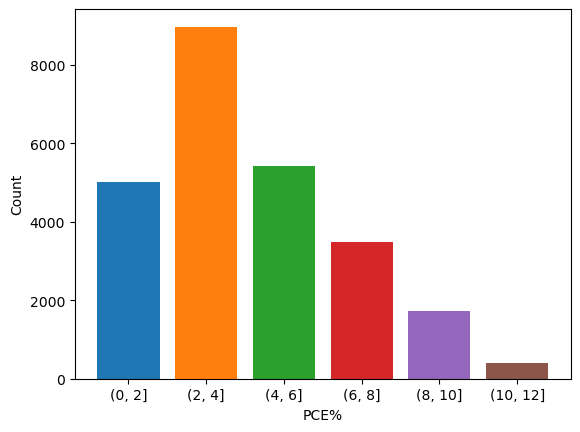

In [10]:
data['pce_pair'] = pd.cut(data['pce'], bins=[0, 2, 4, 6, 8, 10,12])
pce_count = data.groupby('pce_pair').size()

colors = plt.cm.tab10(np.arange(len(pce_count)))

plt.bar(pce_count.index.astype(str), pce_count.values, color=colors)
plt.xlabel('PCE%')
plt.ylabel('Count')
plt.show()



In [10]:
#print(data['SMILES_str'][0])
#Chem.MolFromSmiles(data['SMILES_str'][0])

* Additionals informations

In [11]:
profile = ProfileReport(
    data,
    title="Profiling Report",
    html={'style':{'full_width':True}}
)

profile.to_file(output_file = "data-profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


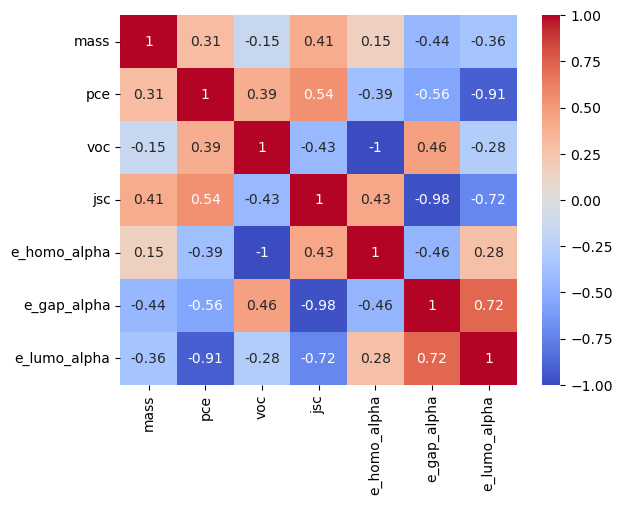

In [11]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

Feature importance using SHAP values based on

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

In [12]:
X=data.drop(["SMILES_str","stoich_str","pce","tmp_smiles_str","pce_pair"],axis=1)
y=data["pce"]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


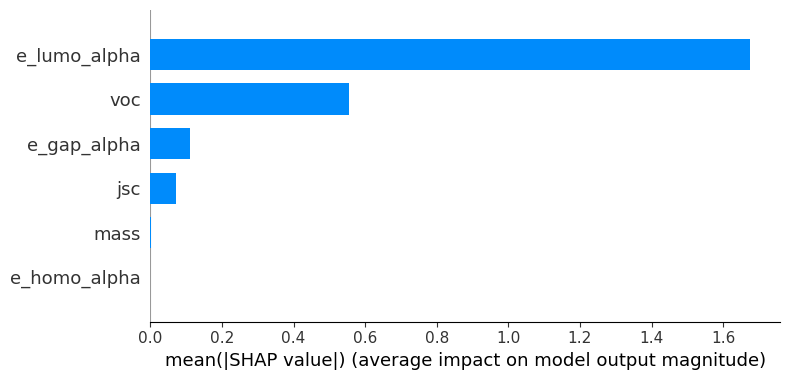

In [14]:
# With XGBOOST
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type='bar', show=False)

In [15]:
# With Random Forest
#from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
#rf = RandomForestRegressor(n_estimators=25,random_state=2)
            
# Fit rf to the training set    
#rf.fit(X, y) 

# Create a SHAP object by using TreeExplainer
#explainer = shap.TreeExplainer(rf)

# Call the explain method by using entry data
#shap_values = explainer(X)

# Display a barplot which show the importance of each features
#shap.summary_plot(shap_values, X, plot_type='bar', show=False)


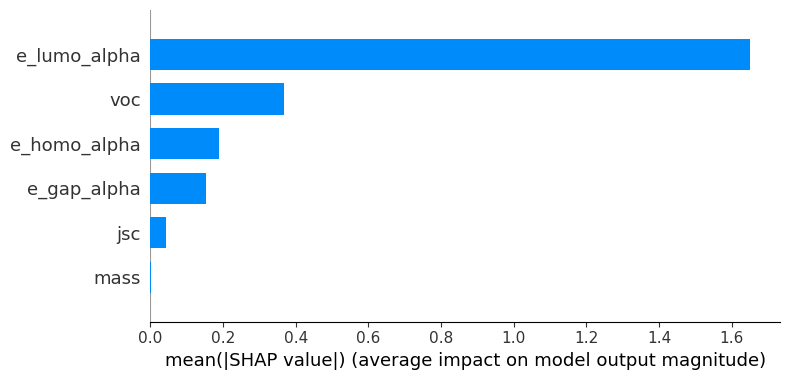

In [16]:
# With decesionTree
from sklearn.tree import DecisionTreeRegressor
# Entraînement du modèle
model = DecisionTreeRegressor(random_state=0)
model.fit(X, y)

# Calcul des valeurs d'importance avec SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Identificaton des features à supprimer
#feature_importance = shap_values.mean(axis=0)
#least_important = feature_importance.argsort()[:5]

# Display a barplot which show the importance of each features
shap.summary_plot(shap_values, X, plot_type='bar', show=False)


In [17]:
# With KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor


# Entraînement du modèle KNN
model = KNeighborsRegressor()
model.fit(X, y)

# Calcul des valeurs d'importance avec SHAP
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)


# Display a barplot which show the importance of each features
shap.summary_plot(shap_values, X, plot_type='bar', show=False)


Exact explainer:  11%|██████▊                                                     | 2820/25000 [01:35<13:24, 27.57it/s]
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?


KeyboardInterrupt: 


Après avoir effectué une analyse approfondie en utilisant les quatre modèles de Machine Learning, à savoir Random Forest, XGBoost, Decision Tree et KNN, il est recommandé de garder tous les features dans le jeu de données. Bien que chaque modèle puisse avoir une importance relative différente pour chaque feature, l'ensemble complet de features offre une variété d'informations qui peuvent améliorer la qualité de la prédiction finale.

De plus, en gardant tous les features, nous avons la possibilité de mettre en place des techniques de feature engineering pour améliorer davantage les performances des modèles. Cela pourrait inclure la création de nouvelles features en combinant ou en transformant des features existants.

En fin de compte, la décision de garder ou de supprimer des features dépendra des objectifs de l'analyse et de la qualité des données. Cependant, dans ce cas, l'ensemble complet de features est recommandé pour tirer le meilleur parti des modèles de Machine Learning utilisés.


# Model Construction 

To select the appropriate regression model , we must train and validate differents models on our train/validation data and compare the metrics

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

In [13]:
X=data.drop(["SMILES_str","stoich_str","pce","tmp_smiles_str","pce_pair"],axis=1)
y=data["pce"]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
def train_validate_models_results(X_train, y_train, X_validation, y_validation, models, metrics):
    results = []
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_validation)
        row = [name]
        for metric_name, metric_func in metrics.items():
            metric_value = metric_func(y_validation, y_pred)
            row.append(metric_value)
        results.append(row)
    df_results = pd.DataFrame(results, columns=['Model'] + list(metrics.keys()))
    return df_results



models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Regressor', KNeighborsRegressor()),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]


metrics = {
    'RMSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R^2': r2_score
}


df=train_validate_models_results(X_train, y_train, X_validation, y_validation, models, metrics)


In [34]:
df

,Model,RMSE,MAE,R^2
0,Decision Tree,0.002483,0.030410,0.999579
1,Random Forest,0.000676,0.014030,0.999886
2,KNN Regressor,3.356897,1.345186,0.430996
3,XGBoost,0.002606,0.033499,0.999558


In [39]:
import seaborn as sns

def plot_models_metrics(df, title):
    
    # Création d'un dataframe pour chaque metrics
    RMSE_df = df[['Model', 'RMSE']].copy()
    MAE_df = df[['Model', 'MAE']].copy()
    R2_df = df[['Model', 'R^2']].copy()
    
    
    # Melt the data frames
    RMSE_df = pd.melt(RMSE_df, id_vars=['Model'], var_name='metric', value_name='value')
    MAE_df = pd.melt(MAE_df, id_vars=['Model'], var_name='metric', value_name='value')
    R2_df = pd.melt(R2_df, id_vars=['Model'], var_name='metric', value_name='value')

    # Créer un bar chart pour chaque metrics
    plt.figure(figsize=(16, 6))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1, 3, 1)
    sns.barplot(x="Model", y="value", data=RMSE_df)
    plt.title("RMSE")

    plt.subplot(1, 3, 2)
    sns.barplot(x="Model", y="value", data=MAE_df)
    plt.title("MAE")

    plt.subplot(1, 3, 3)
    sns.barplot(x="Model", y="value", data=R2_df)
    plt.title("R2")

    plt.tight_layout()
    plt.show()

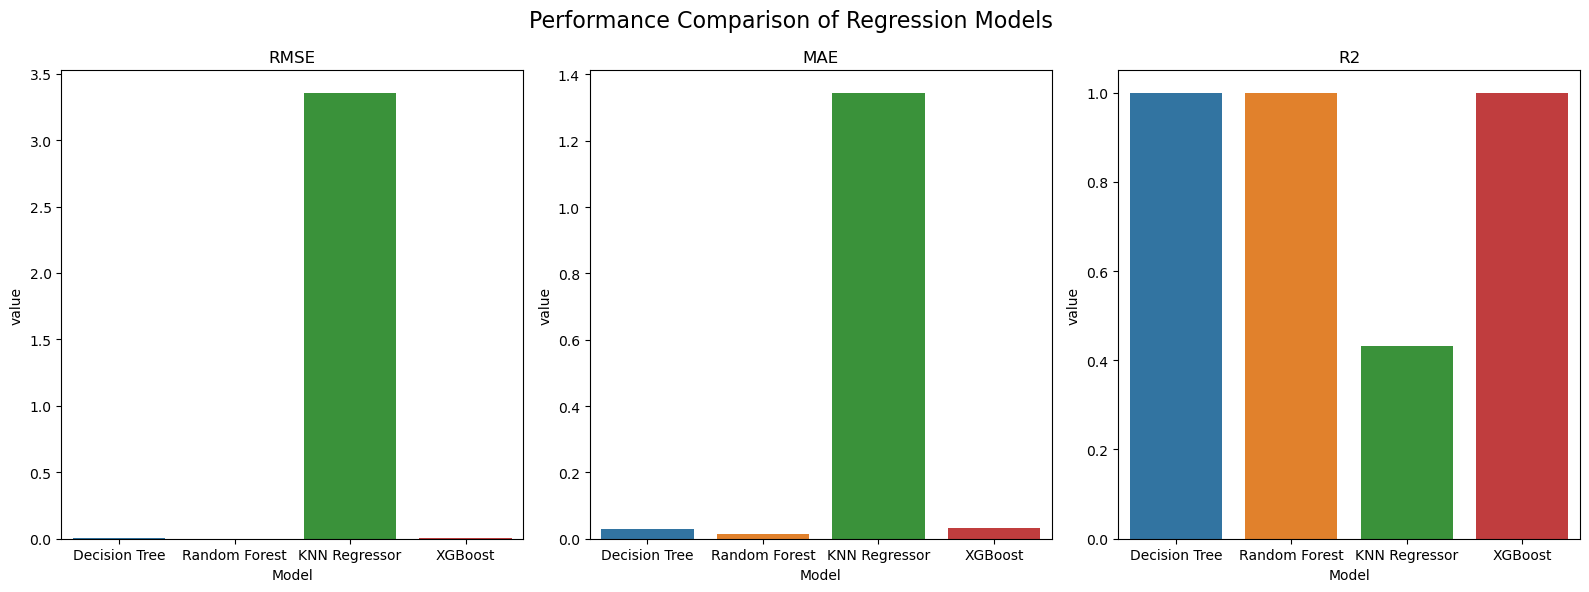

In [40]:
plot_models_metrics(df,title="Performance Comparison of Regression Models ")

In [48]:
# Le KNN Regressor ayant une précision très basse, on va essayer de l'optimiser pour l'améliorer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Create a KNN Regressor object
knn = KNeighborsRegressor()

# Define the hyperparameter grid
param_grid = {'n_neighbors': [9, 11, 13, 15],
              'p': [1, 2, 3],
              'leaf_size': [10, 20, 30, 40, 50]}


# Use Grid Search to find the best hyperparameters
for i in tqdm(range(10)):
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X, y)

    # Print the best hyperparameters
    print("Best hyperparameters:", grid.best_params_)
    pass



 10%|████████▎                                                                          | 1/10 [00:28<04:18, 28.74s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


 20%|████████████████▌                                                                  | 2/10 [01:05<04:25, 33.19s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


 30%|████████████████████████▉                                                          | 3/10 [01:39<03:55, 33.64s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


 40%|█████████████████████████████████▏                                                 | 4/10 [02:10<03:16, 32.75s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:47<02:50, 34.12s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:24<02:21, 35.39s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:07<01:53, 37.72s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:41<01:13, 36.65s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [05:16<00:36, 36.12s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:51<00:00, 35.18s/it]

Best hyperparameters: {'leaf_size': 10, 'n_neighbors': 9, 'p': 1}


In [54]:
# Le KNN Regressor ayant une précision très basse, on va essayer de l'optimiser pour l'améliorer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Create a KNN Regressor object
knn = KNeighborsRegressor(n_neighbors = 9, leaf_size = 10, p = 1)

param_grid = {'weights': ['uniform', 'distance'],
              'p': [1, 2, 3],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}



# Use Grid Search to find the best hyperparameters
for i in tqdm(range(10)):
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X, y)

    # Print the best hyperparameters
    print("Best hyperparameters:", grid.best_params_)
    pass


 10%|████████▏                                                                         | 1/10 [02:23<21:30, 143.40s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


 20%|████████████████▍                                                                 | 2/10 [05:03<20:27, 153.46s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


 30%|████████████████████████▌                                                         | 3/10 [08:08<19:33, 167.58s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


 40%|████████████████████████████████▊                                                 | 4/10 [10:55<16:43, 167.30s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


 50%|█████████████████████████████████████████                                         | 5/10 [13:13<13:04, 156.81s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


 60%|█████████████████████████████████████████████████▏                                | 6/10 [15:32<10:03, 150.87s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [17:49<07:19, 146.40s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [20:12<04:50, 145.18s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [22:49<02:28, 148.75s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [25:24<00:00, 152.41s/it]

Best hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}


In [18]:
model = KNeighborsRegressor(n_neighbors = 9, leaf_size = 10, p = 1, weights = 'distance', algorithm = 'auto')

model.fit(X_train, y_train)  #fit the model
pred = model.predict(X_validation) #make prediction on test set

from sklearn.model_selection import cross_val_score
print(cross_val_score(model, X, y, cv=10, scoring="r2").mean())

# Avec quelques optimisations, on arrive a un meilleur résultat
# mais il reste clairement inférieur aux autres modèles.

0.662616384065749


In [35]:
def train_validate_models_results_cv(X, y, models, metrics, cv):
    results = []
    for model_name, model in models :
        row = [model_name]
        for metric_name, metric_func in metrics.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring=metric_func)
            mean_score = np.mean(scores)
            row.append(mean_score)
        results.append(row)
    df_results = pd.DataFrame(results, columns=['Model'] + list(metrics.keys()))
    return df_results

models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Regressor', KNeighborsRegressor(n_neighbors = 9, leaf_size = 10, p = 1, weights = 'distance', algorithm = 'auto')),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]


metrics = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'R^2': make_scorer(r2_score),
    'Max Error': make_scorer(max_error)
}


df_cv5=train_validate_models_results_cv(X, y, models, metrics,cv=5)

In [36]:
df_cv5

,Model,RMSE,MAE,R^2,Max Error
0,Decision Tree,0.054628,0.031375,0.999478,1.150802
1,Random Forest,0.029430,0.013941,0.999840,0.943866
2,KNN Regressor,1.418789,1.001860,0.652636,6.804970
3,XGBoost,0.052053,0.033237,0.999532,0.932786


In [45]:
import seaborn as sns

def plot_models_metrics_cv(df, title):
    
    # Création d'un dataframe pour chaque metrics
    RMSE_df = df_cv5[['Model', 'RMSE']].copy()
    MAE_df = df_cv5[['Model', 'MAE']].copy()
    R2_df = df_cv5[['Model', 'R^2']].copy()
    MAXE_df = df_cv5[['Model', 'Max Error']].copy()
    
    
    # Melt the data frames
    RMSE_df = pd.melt(RMSE_df, id_vars=['Model'], var_name='metric', value_name='value')
    MAE_df = pd.melt(MAE_df, id_vars=['Model'], var_name='metric', value_name='value')
    R2_df = pd.melt(R2_df, id_vars=['Model'], var_name='metric', value_name='value')
    MAXE_df = pd.melt(MAXE_df, id_vars=['Model'], var_name='metric', value_name='value')

    # Créer un bar chart pour chaque metrics
    plt.figure(figsize=(16, 8))
    plt.suptitle(title, fontsize=16)

    plt.subplot(2, 2, 1)
    sns.barplot(x="Model", y="value", data=RMSE_df)
    plt.title("RMSE")

    plt.subplot(2, 2, 2)
    sns.barplot(x="Model", y="value", data=MAE_df)
    plt.title("MAE")

    plt.subplot(2, 2, 3)
    sns.barplot(x="Model", y="value", data=R2_df)
    plt.title("R2")

    plt.subplot(2, 2, 4)
    sns.barplot(x="Model", y="value", data=MAXE_df)
    plt.title("Max Error")
    
    plt.tight_layout()
    plt.show()

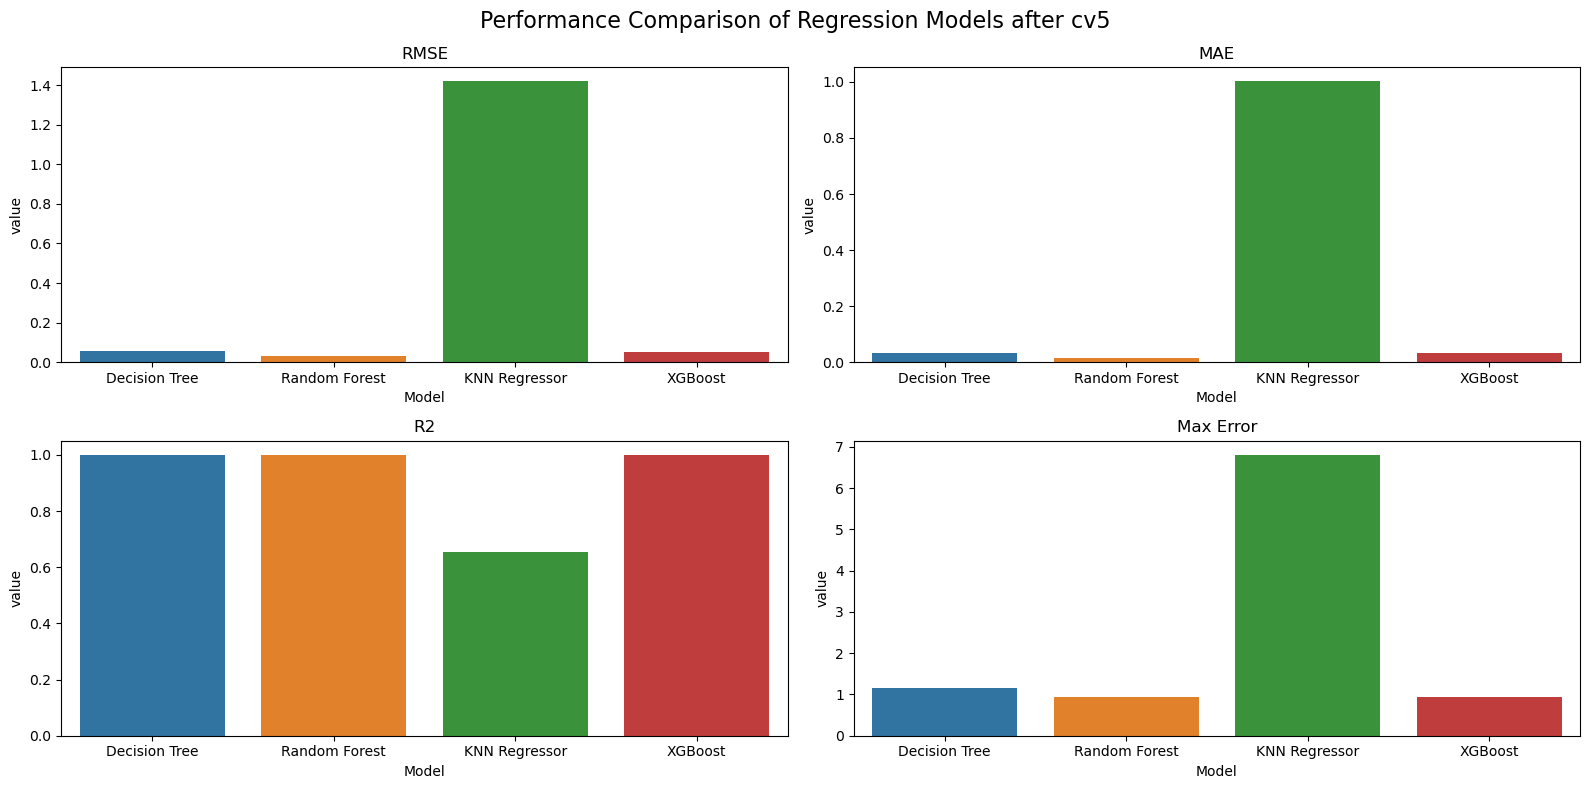

In [46]:
plot_models_metrics_cv(df, title = "Performance Comparison of Regression Models after cv5")

We can see that the Knn Regressor is cleary the worse model. Apart, from that the others models performs very well